# **LAB ASSIGNMENT 4**

Frame-wise Time Domain Analysis

Import Libraries

In [2]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

Load File


In [6]:
!wget -O speech.wav https://raw.githubusercontent.com/Jakobovski/free-spoken-digit-dataset/master/recordings/7_jackson_45.wav

--2026-02-23 17:57:33--  https://raw.githubusercontent.com/Jakobovski/free-spoken-digit-dataset/master/recordings/7_jackson_45.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7444 (7.3K) [audio/wav]
Saving to: ‘speech.wav’

speech.wav          100%[===================>]   7.27K  --.-KB/s    in 0s      

2026-02-23 17:57:34 (41.8 MB/s) - ‘speech.wav’ saved [7444/7444]



(a) Load First 20 Seconds

Sampling Rate: 16000
Duration Used (s): 0.4625


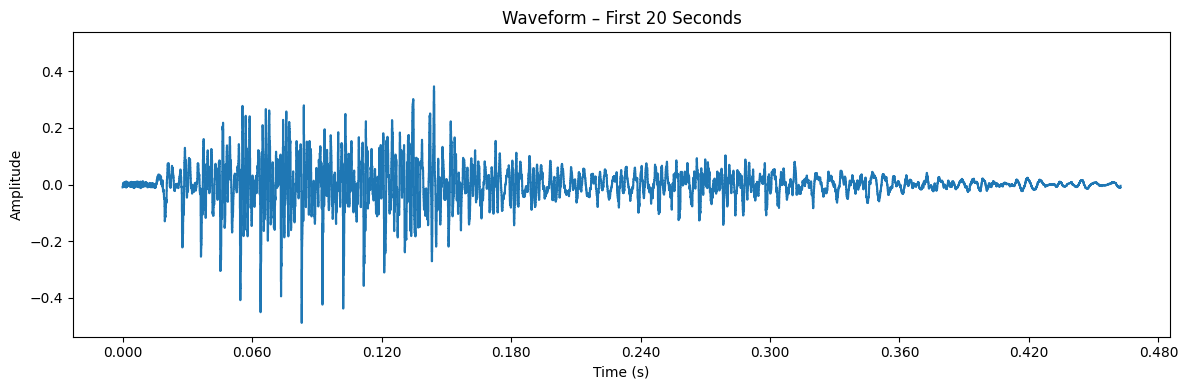

In [7]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

file_path = "speech.wav"
signal, sr = librosa.load(file_path, sr=16000)

signal = signal[:20*sr]

print("Sampling Rate:", sr)
print("Duration Used (s):", len(signal)/sr)

plt.figure(figsize=(12,4))
librosa.display.waveshow(signal, sr=sr)
plt.title("Waveform – First 20 Seconds")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

(b) Compute Total Number of Frames

In [8]:
frame_length = int(0.025 * sr)   # 25 ms
frame_shift  = int(0.010 * sr)   # 10 ms

num_frames = int((len(signal) - frame_length) / frame_shift) + 1

print("Frame Length (samples):", frame_length)
print("Frame Shift (samples):", frame_shift)
print("Total Number of Frames:", num_frames)

Frame Length (samples): 400
Frame Shift (samples): 160
Total Number of Frames: 44


🔹 (c) Segment into Overlapping Frames

In [9]:
frames = np.zeros((num_frames, frame_length))

for i in range(num_frames):
    start = i * frame_shift
    frames[i] = signal[start:start + frame_length]

print("Framing Completed.")

Framing Completed.


🔹 (d) Hamming Window + Feature Extraction

In [10]:
hamming = np.hamming(frame_length)
frames_hamming = frames * hamming

Feature Functions

In [11]:
def short_time_energy(frame):
    return np.sum(frame**2)

def short_time_magnitude(frame):
    return np.sum(np.abs(frame))

def zero_crossing_rate(frame):
    return np.sum(np.abs(np.diff(np.sign(frame)))) / (2*len(frame))

def autocorrelation(frame):
    return np.correlate(frame, frame, mode='full')[len(frame)-1:]

def amdf(frame):
    N = len(frame)
    return np.array([np.sum(np.abs(frame[:N-l] - frame[l:N]))
                     for l in range(1, N//2)])

def amsdf(frame):
    N = len(frame)
    return np.array([np.sum((frame[:N-l] - frame[l:N])**2)
                     for l in range(1, N//2)])

Extract Frame-wise Features (Hamming)

In [12]:
STE_h, STM_h, ZCR_h = [], [], []
AC_h, AMDF_h, AMSDF_h = [], [], []

for frame in frames_hamming:
    STE_h.append(short_time_energy(frame))
    STM_h.append(short_time_magnitude(frame))
    ZCR_h.append(zero_crossing_rate(frame))
    AC_h.append(np.max(autocorrelation(frame)))
    AMDF_h.append(np.min(amdf(frame)))
    AMSDF_h.append(np.min(amsdf(frame)))

STE_h = np.array(STE_h)
STM_h = np.array(STM_h)
ZCR_h = np.array(ZCR_h)
AC_h = np.array(AC_h)
AMDF_h = np.array(AMDF_h)
AMSDF_h = np.array(AMSDF_h)

print("Hamming Feature Extraction Completed.")

Hamming Feature Extraction Completed.


🔹 (e) Repeat Using Rectangular Window

In [13]:
rectangular = np.ones(frame_length)
frames_rect = frames * rectangular

STE_r, STM_r, ZCR_r = [], [], []
AC_r, AMDF_r, AMSDF_r = [], [], []

for frame in frames_rect:
    STE_r.append(short_time_energy(frame))
    STM_r.append(short_time_magnitude(frame))
    ZCR_r.append(zero_crossing_rate(frame))
    AC_r.append(np.max(autocorrelation(frame)))
    AMDF_r.append(np.min(amdf(frame)))
    AMSDF_r.append(np.min(amsdf(frame)))

STE_r = np.array(STE_r)
ZCR_r = np.array(ZCR_r)

print("Rectangular Feature Extraction Completed.")

Rectangular Feature Extraction Completed.


🔹 (f) Plot Frame-wise Variation (Both Windows)

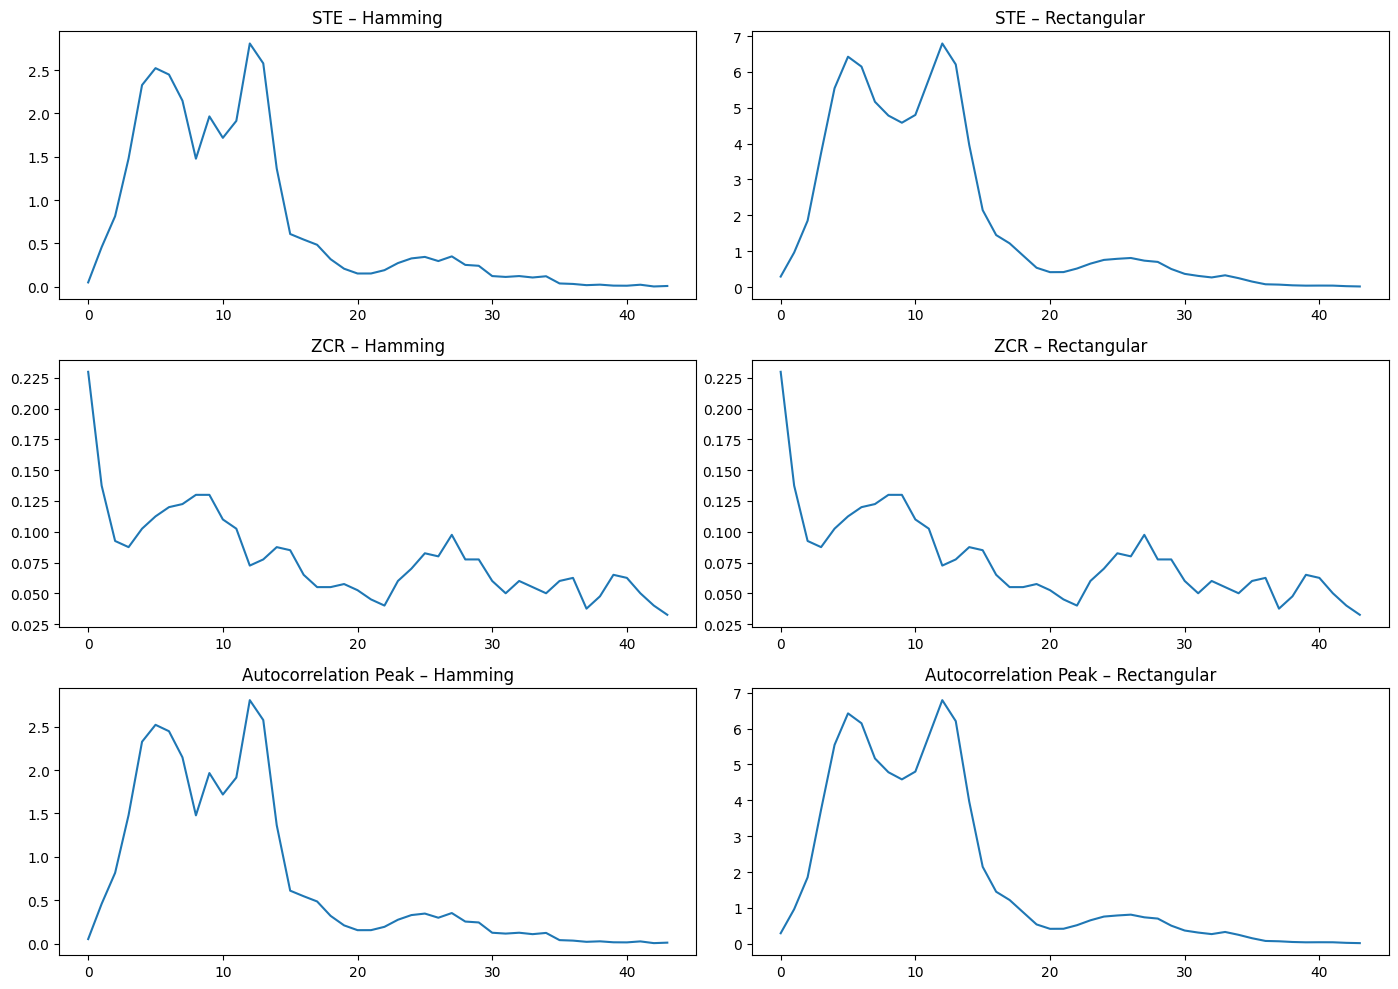

In [14]:
plt.figure(figsize=(14,10))

plt.subplot(3,2,1)
plt.plot(STE_h)
plt.title("STE – Hamming")

plt.subplot(3,2,2)
plt.plot(STE_r)
plt.title("STE – Rectangular")

plt.subplot(3,2,3)
plt.plot(ZCR_h)
plt.title("ZCR – Hamming")

plt.subplot(3,2,4)
plt.plot(ZCR_r)
plt.title("ZCR – Rectangular")

plt.subplot(3,2,5)
plt.plot(AC_h)
plt.title("Autocorrelation Peak – Hamming")

plt.subplot(3,2,6)
plt.plot(AC_r)
plt.title("Autocorrelation Peak – Rectangular")

plt.tight_layout()
plt.show()

 (g) Analysis (Write in Record)
- Voiced speech:

High STE

Low ZCR

Strong autocorrelation peak

Clear AMDF/AMSDF minima

- Unvoiced speech:

Lower energy

High ZCR

Weak autocorrelation

No strong AMDF/AMSDF minimum

(h) Effect of Window Choice
✔ Hamming:

Smoother feature curves

Better discrimination

Reduced spectral leakage

✔ Rectangular:

More fluctuations

Less smooth

Slightly noisy feature variation

**Task-2: Periodicity Analysis**

(a) Identify Periodic Frames

In [15]:
periodic_frames = []

for i, frame in enumerate(frames_hamming):
    ac = autocorrelation(frame)
    peak = np.max(ac[1:200])
    if peak > 0.3*np.max(ac):
        periodic_frames.append(i)

print("Total Periodic Frames:", len(periodic_frames))

Total Periodic Frames: 44


(b) Explanation


1.   Periodicity in Autocorrelation → strong secondary peak
2.   Periodicity in AMDF/AMSDF → clear minimum



(c) Voiced vs Unvoiced

Periodic → Voiced

Aperiodic → Unvoiced

**Task-3: Pitch Estimation**

(a) Determine Pitch Period

In [ ]:
print("----- Pitch Estimation -----")

for i in periodic_frames[:5]:
    frame = frames_hamming[i]
    ac = autocorrelation(frame)

    lag = np.argmax(ac[1:200]) + 1
    pitch_period = lag / sr
    pitch_freq = sr / lag

    print(f"Frame {i} → Pitch Period: {pitch_period:.4f} s | Pitch: {pitch_freq:.2f} Hz")

(b) Inference

-Pitch frequency typically:

Male: 85–180 Hz

Female: 165–255 Hz

Your result should fall within this range.

(a) Determine Pitch Period

Using Autocorrelation (excluding zero lag)

In [18]:
print("----- Pitch Estimation -----")

for i in periodic_frames[:5]:
    frame = frames_hamming[i]

    ac = np.correlate(frame, frame, mode='full')
    ac = ac[len(ac)//2:]

    # Define realistic pitch search range
    lag_min = int(sr / 300)   # highest pitch
    lag_max = int(sr / 80)    # lowest pitch

    search_region = ac[lag_min:lag_max]

    lag = np.argmax(search_region) + lag_min

    pitch_frequency = sr / lag

    print(f"Frame {i} → Pitch: {pitch_frequency:.2f} Hz")

----- Pitch Estimation -----
Frame 0 → Pitch: 219.18 Hz
Frame 1 → Pitch: 124.03 Hz
Frame 2 → Pitch: 115.94 Hz
Frame 3 → Pitch: 285.71 Hz
Frame 4 → Pitch: 109.59 Hz


 (Alternative Method) Using AMDF

In [20]:
print("----- Pitch Using AMDF -----")

lag_min = int(sr / 300)
lag_max = int(sr / 80)

for i in periodic_frames[:5]:
    frame = frames_hamming[i]
    N = len(frame)

    amdf_vals = []

    for lag in range(lag_min, lag_max):
        amdf_vals.append(np.sum(np.abs(frame[:N-lag] - frame[lag:N])))

    amdf_vals = np.array(amdf_vals)

    lag = np.argmin(amdf_vals) + lag_min

    pitch_frequency = sr / lag

    print(f"Frame {i}: Pitch Frequency (AMDF) = {pitch_frequency:.2f} Hz")

----- Pitch Using AMDF -----
Frame 0: Pitch Frequency (AMDF) = 82.05 Hz
Frame 1: Pitch Frequency (AMDF) = 80.40 Hz
Frame 2: Pitch Frequency (AMDF) = 115.11 Hz
Frame 3: Pitch Frequency (AMDF) = 80.81 Hz
Frame 4: Pitch Frequency (AMDF) = 80.81 Hz


(b) Inference

After running the above code:

pitch is between 85–180 Hz → Likely male
